In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from enum import IntEnum
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import trange
from collections import defaultdict

from GrU_nn import (gru_module_1, gru_module_2, gru_module_3, gru_module_4, neuralGrU)
from GrU import (evaluate, GrU, getBestExporter, getCost)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

### Load auction data

In [3]:
class clock( IntEnum ):
    pv = 0
    storage = 1
    charge = 2
    discharge = 3

class source( IntEnum ):
    grid =  0
    pv = 1
    storage = 2
    charge = 3
    discharge = 4

df_auctioneer_data = pd.read_csv('../data/Auctioneer Data.csv')

headers = np.load(file='../data/clock_data_columns.npy', allow_pickle=True)
df_clock_data = pd.DataFrame(np.load('../data/clock_data_values.npy', allow_pickle=True), columns=headers)

def getPriceVectors(round):
    '''
    Get price vectors for a round from the clock data.

    Parameters
    ----------
    round : int
        Round number to get the price vectors for, range = [0, 308]

    Returns
    -------
    prices : ndarray of shape (5, 24)
        Price vectors for g, p, s, c, d.
    
    '''
    prices = np.ndarray((5, 24))
    prices[0] = df_auctioneer_data.GRID_PRICE.values
    for e in clock:
        prices[e + 1] = df_clock_data[f'price_{round}'][e]
    return prices

## Revenue Maximisation

In [302]:
def total_loss(pi_g, pi_p, pi_s, pi_c, pi_d, d_star):
    '''
    Loss = -revenue
    '''
    # r_g = pi_g * d_star[source.grid]
    r_p = pi_p * d_star[source.pv]
    r_s = pi_s * d_star[source.storage]
    r_c = pi_c * d_star[source.charge]
    r_d = pi_d * d_star[source.discharge]

    r_t = r_p + r_s + r_c + r_d
    rev = torch.sum(r_t)

    return -rev

In [319]:
# Init model
eta = 0.9487
scaler = 1
model = neuralGrU(B=64, eta_c=eta, eta_d=eta, alpha=1e3).to(device)

#### Input Data

In [320]:
# # Price vectors sampled from Normal Distribution(mu=0, sigma=1)
# prices = np.abs(np.random.normal(loc=0, scale=1, size=(5, 24))) * scaler

> Hyperparameters: lr = 0.125, gamma = 0.94, B = 5, scaler = 1, Curriculum Learning & ExponentialLR Scheduler

In [321]:
# Price vectors sampled from Uniform Distribution [0, 1)
prices = np.random.random(size=(5, 24)) * scaler

> Hyperparameters: lr = 0.1, gamma = 0.94, B = 5, scaler = 1, Curriculum Learning & ExponentialLR Scheduler

In [322]:
# # Price vectors from Auction Data
# prices = getPriceVectors(300) * scaler

> Hyperparameters: lr = 1, gamma = 0.92, B = 1, scaler = 1 Curriculum Learning & ExponentialLR Scheduler

In [329]:
# Total demand tensor (Unit)
d_t = torch.ones(24, requires_grad=False, device=device) * 10
# d_t = torch.ones(24, requires_grad=False, device=device)

# Cap tensor
C_p = torch.ones(24, requires_grad=False) * 4
C_d = torch.ones(24, requires_grad=False) * 4

grid_shift = 0

# Price tensors
pi_g = torch.tensor(prices[source.grid] + grid_shift, requires_grad=False, device=device)

pi_p = torch.tensor(prices[source.pv],  requires_grad=True, device=device)
pi_c = torch.tensor(prices[source.charge], requires_grad=True, device=device)
pi_d = torch.tensor(prices[source.discharge], requires_grad=True, device=device)
pi_s = torch.tensor(prices[source.storage], requires_grad=True, device=device)

#### Optimisation schedule

In [330]:
# Hyperparameter(s)
learning_rate = 0.008
epochs = 500

history = []
best_loss = 0

# Init optimizer & scheduler
optimizer = torch.optim.Adam([pi_p, pi_s, pi_c, pi_d], lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)

for t in trange(epochs):
    # Compute prediction and loss
    d_star = model(pi_g, pi_p, pi_s, pi_c, pi_d, d_t, C_p=C_p, C_d=C_d)
    loss = total_loss(pi_g, pi_p, pi_s, pi_c, pi_d, d_star)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()

    # Optimisation
    optimizer.step()
    scheduler.step()

    loss = loss.item()
    history.append(loss / scaler)

    if loss < best_loss:
        pi_optimal, best_loss = [], loss
        for pi in pi_p, pi_s, pi_c, pi_d:
            pi_optimal.append(pi.clone().detach())

    # Curriculum Learning
    if t % 10 == 0 and model.B < 1e4:
        model.B *= 2

    # if t % 100 == 0:
    #     print(f"Epoch {t+1}     loss: {loss:>7f}")

100%|██████████| 500/500 [00:03<00:00, 155.70it/s]


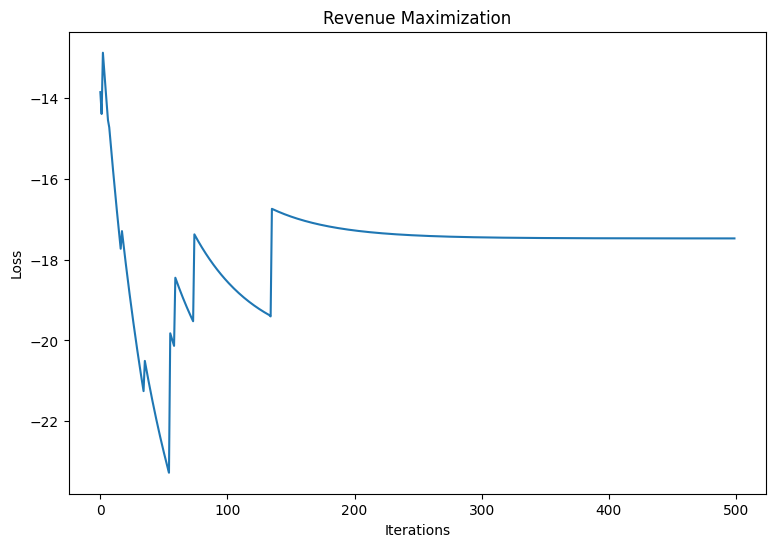

In [331]:
plt.figure(figsize=(9,6))
plt.plot(history, label='loss')
plt.title('Revenue Maximization')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [326]:
best_loss, loss

(-36.84369274578628, -25.56480259128698)

In [327]:
pi_optimal

[tensor([0.1298, 0.6046, 0.5676, 0.7235, 0.5925, 0.1835, 0.4189, 0.5805, 0.2074,
         0.8885, 0.0035, 0.6942, 0.7595, 0.3683, 0.7788, 0.4411, 0.2036, 0.5173,
         0.7164, 0.5659, 0.4751, 0.4370, 0.5996, 0.1494], dtype=torch.float64),
 tensor([0.2396, 0.5072, 0.9935, 0.4365, 0.0668, 0.3032, 0.2514, 0.7157, 0.6962,
         0.5239, 0.1585, 0.5176, 0.2095, 0.0749, 0.8435, 0.4802, 0.4893, 0.6847,
         0.2766, 0.9554, 0.8167, 0.6713, 0.4329, 0.3005], dtype=torch.float64),
 tensor([0.8451, 0.7723, 0.7146, 0.6762, 0.2383, 0.7444, 0.2601, 0.6654, 0.9333,
         0.6916, 0.3301, 0.3770, 0.1522, 0.3395, 0.6053, 0.2462, 0.1033, 0.5383,
         0.4248, 0.0330, 0.7542, 0.2592, 0.3886, 0.2563], dtype=torch.float64),
 tensor([0.6297, 0.9055, 0.7472, 0.4696, 0.2925, 0.7462, 0.2819, 0.2846, 0.5693,
         0.3374, 0.2732, 0.7765, 0.8554, 0.1545, 0.6107, 0.4099, 0.5327, 0.8424,
         0.4230, 0.4828, 0.5798, 0.5730, 0.2766, 0.4032], dtype=torch.float64)]

In [36]:
torch.round(pi_g - pi_p, decimals=2)

tensor([ 0.0300, -0.6200, -0.2500, -0.3700,  0.0000, -0.3800, -0.5600,  0.2200,
        -0.2700,  0.0000, -0.5000,  0.0100,  0.1300, -0.8800,  0.0200,  0.0000,
         0.0000, -0.1500, -0.3100, -0.0700,  0.0300,  0.0200, -0.8100,  0.2000],
       dtype=torch.float64, grad_fn=<RoundBackward1>)

In [332]:
torch.round(d_star, decimals=2)

tensor([[10.,  6., 10., 10., 10., 10.,  6.,  6., 10., 10., 10., 10., 10.,  6.,
         10., 10., 10., 10., 10., 10.,  6.,  6.,  6., 10.],
        [ 0.,  4.,  0.,  0.,  0.,  0.,  4.,  4.,  0.,  0.,  0.,  0.,  0.,  4.,
          0.,  0.,  0.,  0.,  0.,  0.,  4.,  4.,  4.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]],
       dtype=torch.float64, grad_fn=<RoundBackward1>)

In [335]:
pi_p, pi_s, pi_c, pi_d = pi_optimal
model(pi_g, pi_p, pi_s, pi_c, pi_d, d_t, C_p=C_p, C_d=C_d).round(decimals=3)

tensor([[10.,  6., 10., 10., 10., 10.,  6.,  6., 10., 10., 10., 10., 10.,  6.,
         10.,  6., 10.,  6., 10.,  6.,  6.,  6.,  6., 10.],
        [ 0.,  4.,  0.,  0.,  0.,  0.,  4.,  4.,  0.,  0.,  0.,  0.,  0.,  4.,
          0.,  4.,  0.,  4.,  0.,  4.,  4.,  4.,  4.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]],
       dtype=torch.float64, grad_fn=<RoundBackward1>)

#### Demand breakup on optimised prices

In [336]:
pi = torch.stack([pi_g, pi_p, pi_s, pi_c, pi_d]).detach().numpy()

In [337]:
d_break_nn = model(pi_g, pi_p, pi_s, pi_c, pi_d, d_t).detach().numpy()
d_break, _ = GrU(d_t, pi, eta_c=eta, eta_d=eta)

In [338]:
evaluate(d_break, d_break_nn)[0]

[1.0186518295540736e-11, 1.0186483285313914e-11, 0.0, 0.0, 0.0]

In [343]:
d_break_nn - d_break

array([[ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        -2.44476439e-010,  0.00000000e+000,  0.00000000e+000,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         8.28616997e-124,  0.00000000e+000,  0.00000000e+000,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000],
       [ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         2.44475599e-010,  0.00000000e+000,  0.00000000e+000,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000],
      

In [339]:
d_break

array([[10.,  0., 10., 10., 10., 10.,  0.,  0., 10., 10., 10., 10., 10.,
         0., 10.,  0., 10.,  0., 10.,  0.,  0.,  0.,  0., 10.],
       [ 0., 10.,  0.,  0.,  0.,  0., 10., 10.,  0.,  0.,  0.,  0.,  0.,
        10.,  0., 10.,  0., 10.,  0., 10., 10., 10., 10.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

## Revenue Maximisation with Gradient Clipping

1. No Curriculum Learning (for B). Init B at 10-20.
2. Gradients clipped at 0, i.e., updates to price(s) are non-negative.
3. Input price tensors are scaled to compensate for lower B.
4. ExponentialLR performs better than ReduceLROnPlateau.

In [298]:
def total_loss(pi_g, pi_p, pi_s, pi_c, pi_d, d_star):
    '''
    Loss = -revenue
    '''
    # r_g = pi_g * d_star[source.grid]
    r_p = pi_p * d_star[source.pv]
    r_s = pi_s * d_star[source.storage]
    r_c = pi_c * d_star[source.charge]
    r_d = pi_d * d_star[source.discharge]

    r_t = r_p + r_s + r_c + r_d
    rev = torch.sum(r_t)

    return -rev

In [810]:
# Init model
eta = 1
B = 256
scaler = 1

model = neuralGrU(B, device, eta, eta).to(device)

#### Input Data

In [823]:
# prices = getPriceVectors(100) * scaler
scaled_prices = prices * scaler

# Random total demand tensor
d_t = torch.ones(24, requires_grad=False, device=device)
# d_t = torch.ones(24, requires_grad=False, device=device)

# Price tensors
pi_g = torch.tensor(scaled_prices[source.grid] + grid_shift, requires_grad=False, device=device)

pi_p = torch.tensor(scaled_prices[source.pv],  requires_grad=True, device=device)
pi_c = torch.tensor(scaled_prices[source.charge], requires_grad=True, device=device)
pi_d = torch.tensor(scaled_prices[source.discharge], requires_grad=True, device=device)
pi_s = torch.tensor(scaled_prices[source.storage], requires_grad=True, device=device)

#### Optimization schedule

In [824]:
# Hyperparameter(s)
learning_rate = 0.025
epochs = 500

history_grad_clip = []

# Init optimizer & scheduler
optimizer = torch.optim.Adam([pi_p, pi_s, pi_c, pi_d], lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.982)

for t in trange(epochs):
    # Compute prediction and loss
    d_star = model(pi_g, pi_p, pi_s, pi_c, pi_d, d_t)
    loss = total_loss(pi_g, pi_p, pi_s, pi_c, pi_d, d_star)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    
    # Gradient Clipping
    for p in [pi_p, pi_s, pi_c, pi_d]:
        p.grad = -F.relu(-p.grad)

    optimizer.step()
    scheduler.step()

    loss = loss.item()
    history_grad_clip.append(loss / scaler)

    # Curriculum Learning
    if t % 10 == 0 and model.B < 1e4:
        model.B *= 2

    # if t % 100 == 0:
    #     print(f"Epoch {t+1}     loss: {loss:>7f}")

100%|██████████| 500/500 [00:03<00:00, 162.10it/s]


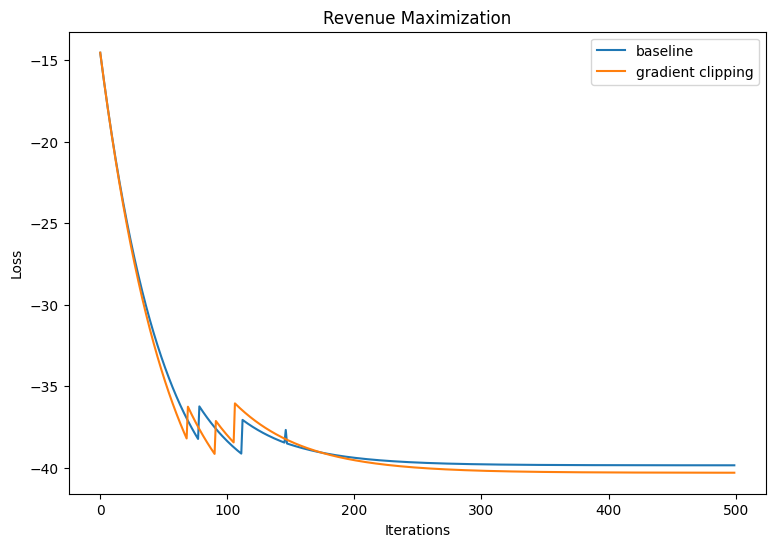

In [825]:
plt.figure(figsize=(9,6))
plt.plot(history, label='baseline')
plt.plot(history_grad_clip, label='gradient clipping')
plt.title('Revenue Maximization')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [558]:
(pi_g > pi_p).all()

tensor(True)

In [826]:
(pi_g - pi_p) / scaler

tensor([ 0.3661,  1.8690,  0.5150, -0.0408, -0.0312,  0.8866,  0.1038,  0.3904,
         1.3893,  0.8990,  0.1514,  1.9923,  0.6137,  0.7580,  0.5715,  0.3316,
         0.6517, -0.0619,  0.7804,  0.6153,  0.7038,  1.8420,  1.2148,  0.4223],
       dtype=torch.float64, grad_fn=<DivBackward0>)

In [827]:
np.round(d_star.detach().numpy())

array([[0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]])

## Multi-agent Revenue Maximization

In [284]:
def total_loss(pi_g, pi_p, pi_s, pi_c, pi_d, d_star):
    '''
    Loss = -revenue
    '''
    # r_g = pi_g * d_star[source.grid]
    r_p = pi_p * d_star[source.pv]
    r_s = pi_s * d_star[source.storage]
    r_c = pi_c * d_star[source.charge]
    r_d = pi_d * d_star[source.discharge]

    r_t = r_p + r_s + r_c + r_d
    rev = torch.sum(r_t)

    return -rev


def barrier_loss(C_g, C, epsilon, nan=1e3):
    '''
    Barrier function with barrier at C_g & sensitivity epsilon
    '''
    b = F.relu(-torch.log((C_g - C)/epsilon))

    return torch.sum(b)

In [285]:
prices = np.random.random((5, 24))

# Total demand tensor
d_t = torch.ones(24, requires_grad=False, device=device) * 2

# Global constraint
C_global = torch.ones(24, requires_grad=False, device=device) * 8

# Price tensors
pi_g = torch.tensor(prices[source.grid], requires_grad=False, device=device)

pi_p = torch.tensor(prices[source.pv], requires_grad=True, device=device)
pi_c = torch.tensor(prices[source.charge] * 1e3, requires_grad=True, device=device)
pi_d = torch.tensor(prices[source.discharge] * 1e3, requires_grad=True, device=device)
pi_s = torch.tensor(prices[source.storage] * 1e3, requires_grad=True, device=device)

# EI tensor
ep = [0.00044688, 0.00044796, 0.00045042, 0.00045573, 0.00046029, 0.00046002, 0.00045153, 0.00043737, 0.00042772, 0.00041107, 0.00040774, 0.00038668, 0.00037268, 0.00036565, 0.00036387, 0.00035763, 0.00034319, 0.00034377, 0.00035285, 0.00037902, 0.00039631, 0.00040366, 0.00039713, 0.00039088]
ep_t = torch.tensor(ep, requires_grad=False, device=device) * 1e3

In [286]:
n_agents = 5
gamma = [1, 2, 3, 4, 5]

models = {i: neuralGrU(B=64).to(device) for i in range(n_agents)}
d_star_n = torch.tensor(np.ndarray(shape=(n_agents, 5, 24)), device=device)
C_n = torch.ones(size=(n_agents, 24), requires_grad=True, device=device)

# Hyperparameter(s)
learning_rate = 0.01
epochs = 500
epsilon = 0.1
nan = 1e3

history = []

optimizer = torch.optim.Adam([pi_p, pi_s, pi_c, pi_d, C_n], lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)

for t in trange(epochs):
    for agent in range(n_agents):
        # Update pi_g with EI
        pi_g_ei = pi_g + gamma[agent] * ep_t
        d_star_n[agent] = models[agent](pi_g_ei, pi_p, pi_s, pi_c, pi_d, d_t, C_p=C_n[agent].clone())

    d_star_total = torch.sum(d_star_n, dim=0)
    C = torch.sum(C_n, dim=0)

    loss = total_loss(pi_g, pi_p, pi_s, pi_c, pi_d, d_star_total) + barrier_loss(C_global, C, epsilon, nan)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward(retain_graph=True)

    # Optimisation
    optimizer.step()
    scheduler.step()

    loss = loss.item()
    history.append(loss)

    # Curriculum Learning
    for agent in range(n_agents):
        if t % 10 == 0 and models[agent].B < 1e4:
            models[agent].B *= 2

100%|██████████| 500/500 [37:53<00:00,  4.55s/it]


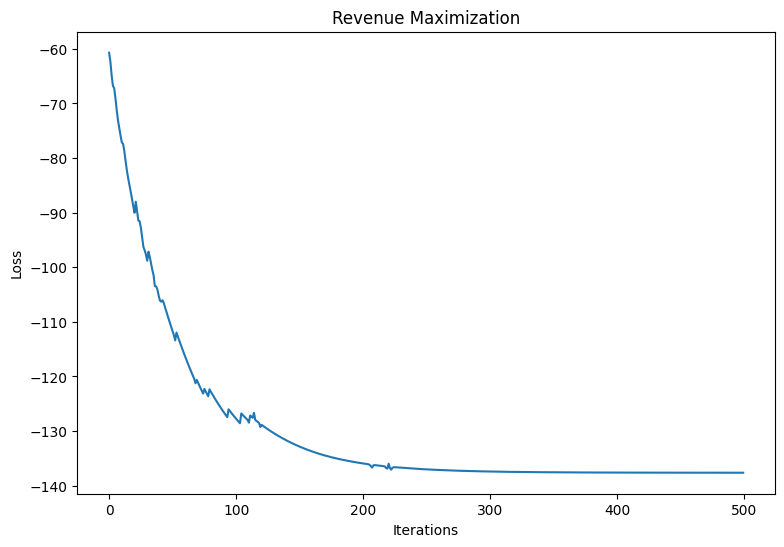

In [287]:
plt.figure(figsize=(9,6))
plt.plot(history)
plt.title('Revenue Maximization')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [288]:
pi_p

tensor([1.0412, 0.9984, 0.5457, 0.6951, 1.4484, 0.8578, 1.2761, 1.0219, 0.6649,
        0.5707, 0.9221, 0.6129, 0.8120, 0.6695, 0.9163, 0.8787, 0.6729, 0.9464,
        1.2877, 0.8438, 0.5676, 0.8736, 0.9190, 0.7962], dtype=torch.float64,
       requires_grad=True)

In [298]:
ep_t * 1 + pi_g - pi_p

tensor([-5.5291e-01, -4.4312e-01,  1.3945e-03,  2.6950e-01, -5.0864e-01,
         7.7722e-03, -7.5236e-02, -1.7240e-01,  2.3357e-01,  3.2555e-01,
         2.7539e-01,  6.7544e-01, -3.9518e-01, -2.6964e-02,  2.1094e-02,
         1.1501e-02, -1.9747e-02, -1.1838e-02, -7.3796e-02, -3.7239e-01,
         5.3850e-01,  6.2404e-04,  5.4911e-02,  3.0272e-01],
       dtype=torch.float64, grad_fn=<SubBackward0>)

In [294]:
pi_g - pi_p

tensor([-0.9998, -0.8911, -0.4490, -0.1862, -0.9689, -0.4522, -0.5268, -0.6098,
        -0.1942, -0.0855, -0.1323,  0.2888, -0.7679, -0.3926, -0.3428, -0.3461,
        -0.3629, -0.3556, -0.4266, -0.7514,  0.1422, -0.4030, -0.3422, -0.0882],
       dtype=torch.float64, grad_fn=<SubBackward0>)

### Local PV Constraint

In [299]:
C_n

tensor([[1.0000, 1.0000, 1.5298, 1.5729, 1.0000, 1.5051, 1.4364, 1.3770, 1.5780,
         1.5800, 1.5486, 1.5800, 1.0000, 1.2381, 1.5490, 1.4032, 1.3630, 1.3494,
         1.4617, 1.0000, 1.5800, 1.4011, 1.5488, 1.5597],
        [1.4355, 1.4419, 1.5354, 1.5729, 1.4706, 1.5163, 1.5299, 1.5407, 1.5780,
         1.5800, 1.5486, 1.5800, 1.3198, 1.5050, 1.5490, 1.5000, 1.5151, 1.5014,
         1.5312, 1.3936, 1.5800, 1.5015, 1.5488, 1.5597],
        [1.5402, 1.5034, 1.5354, 1.5729, 1.5265, 1.5163, 1.5299, 1.5407, 1.5780,
         1.5800, 1.5486, 1.5800, 1.5262, 1.5050, 1.5490, 1.5000, 1.5151, 1.5014,
         1.5312, 1.5007, 1.5800, 1.5015, 1.5488, 1.5597],
        [1.5402, 1.5034, 1.5354, 1.5729, 1.5265, 1.5163, 1.5299, 1.5407, 1.5780,
         1.5800, 1.5486, 1.5800, 1.5262, 1.5050, 1.5490, 1.5000, 1.5151, 1.5014,
         1.5312, 1.5007, 1.5800, 1.5015, 1.5488, 1.5597],
        [1.5402, 1.5034, 1.5354, 1.5729, 1.5265, 1.5163, 1.5299, 1.5407, 1.5780,
         1.5800, 1.5486, 1.5800, 1.5262

### Total PV demand of all agents

In [300]:
torch.sum(d_star_n[:, 1], dim=0)

tensor([4.6207, 5.9522, 7.6713, 7.8646, 4.5795, 7.5702, 6.1196, 6.1630, 7.8902,
        7.9000, 7.7431, 7.9000, 4.5787, 6.0200, 7.7452, 7.4031, 6.0605, 6.0054,
        6.1247, 5.8957, 7.9000, 7.4069, 7.7442, 7.7983], dtype=torch.float64,
       grad_fn=<SumBackward1>)

In [301]:
torch.round(d_star_n[:, 1], decimals=2)

tensor([[0.0000, 0.0000, 1.5300, 1.5700, 0.0000, 1.5100, 0.0000, 0.0000, 1.5800,
         1.5800, 1.5500, 1.5800, 0.0000, 0.0000, 1.5500, 1.4000, 0.0000, 0.0000,
         0.0000, 0.0000, 1.5800, 1.4000, 1.5500, 1.5600],
        [0.0000, 1.4400, 1.5400, 1.5700, 0.0000, 1.5200, 1.5300, 1.5400, 1.5800,
         1.5800, 1.5500, 1.5800, 0.0000, 1.5100, 1.5500, 1.5000, 1.5200, 1.5000,
         1.5300, 1.3900, 1.5800, 1.5000, 1.5500, 1.5600],
        [1.5400, 1.5000, 1.5400, 1.5700, 1.5300, 1.5200, 1.5300, 1.5400, 1.5800,
         1.5800, 1.5500, 1.5800, 1.5300, 1.5100, 1.5500, 1.5000, 1.5200, 1.5000,
         1.5300, 1.5000, 1.5800, 1.5000, 1.5500, 1.5600],
        [1.5400, 1.5000, 1.5400, 1.5700, 1.5300, 1.5200, 1.5300, 1.5400, 1.5800,
         1.5800, 1.5500, 1.5800, 1.5300, 1.5100, 1.5500, 1.5000, 1.5200, 1.5000,
         1.5300, 1.5000, 1.5800, 1.5000, 1.5500, 1.5600],
        [1.5400, 1.5000, 1.5400, 1.5700, 1.5300, 1.5200, 1.5300, 1.5400, 1.5800,
         1.5800, 1.5500, 1.5800, 1.5300

> PV demand of all 5 users